In [ ]:
import fastai, torch

In [ ]:
fastai.__version__ , torch.__version__

('1.0.61', '1.5.1+cu101')

In [ ]:
from urllib.request import urlopen
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import os
import re

In [ ]:
df = pd.read_csv('drive/My Drive/nlp-telugu/inltk/dataset/telugu_wiki_links.csv')
unique_links = df['link'].values

In [ ]:
def readout_buffer(response):
    response.text = response.read()
    return response.text.decode('utf-8')

    
def get_data_from_url(url):
    try:
        r = urlopen(url)
        doc = readout_buffer(r)
    except Exception as e:
        # print(e)
        doc = ""
    return doc

In [ ]:
!pip install selectolax
from selectolax.parser import HTMLParser
def get_details(url):
    doc = get_data_from_url(url)
    try: 
        html_doc = HTMLParser(doc)
        t = '\n '.join(n.text() for n in html_doc.css("title"))
        a = '\n '.join(n.text() for n in html_doc.css("p"))
    except:
        t = ""
        a = ""
    return t, a

In [ ]:
from datetime import datetime
import multiprocessing as mp
import multiprocessing.dummy as mpd
import time

start = datetime.now()
cpu_cores = mp.cpu_count()
print('parallelising the task on {} cpu cores'.format(cpu_cores))

rows = []
count = 0
# divide pool
pool = mpd.Pool(processes=cpu_cores)
# iter over 
for row in pool.imap(get_details, unique_links):
    rows.append(row)    
    count = count + 1
    # print/save
    if not count%100:
        print('done for,', count)
    if not count%10000:
        df = pd.DataFrame(rows, columns = ['title', 'text'])
        df.to_parquet('telugu_wikipedia_dataset.parquet', index = None)
        print("Done for {} rows ---> {}".format(count, datetime.now() - start))
# close the pool
pool.close()
pool.join()


In [2]:
from fastai.text import *
import numpy as np
from sklearn.model_selection import train_test_split
import pickle
import sentencepiece as spm

In [1]:
!pip install sentencepiece

In [3]:
import fastai, torch
fastai.__version__ , torch.__version__

('1.0.61', '1.5.1+cu101')

In [4]:
df = pd.read_parquet('drive/My Drive/nlp-telugu/telugu_wikipedia_dataset.parquet')

In [7]:
df.shape, df.columns

((90000, 2), Index(['title', 'text'], dtype='object'))

In [8]:
texts = df['text'].tolist()
texts = [t for t in texts if len(t.strip())>1]
print(len(texts))

83953


In [9]:
df2 = pd.DataFrame(texts, columns = ['text'])

In [10]:
del df, texts
gc.collect()

33

In [11]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df2, test_size=0.2, random_state=42)
train_df.shape, test_df.shape

((67162, 1), (16791, 1))

In [ ]:
train_df.to_parquet('telugu_wiki_train.parquet', index = None)
test_df.to_parquet('telugu_wiki_test.parquet', index = None)

In [10]:
!pwd

/content


In [12]:
from inltk.tokenizer import TeluguTokenizer

In [13]:
sp = spm.SentencePieceProcessor()
sp.Load('tokenizer.model')
itos = [sp.IdToPiece(int(i)) for i in range(25000)] # 25,000 is the vocab_size selected in sm tokenizer
telugu_vocab = Vocab(itos)

In [14]:
tokenizer = Tokenizer(tok_func=TeluguTokenizer, lang='te')

In [15]:
tokenizer.special_cases

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep']

In [16]:
torch.cuda.set_device(0)

In [17]:
data_lm = TextLMDataBunch.from_df('/content/', train_df=train_df, valid_df=test_df,
                                  text_cols=["text"], bs=96,
                                  tokenizer=tokenizer, vocab=telugu_vocab) # default bs=64
data_lm.save('telugu_lm.data')


In [18]:
data_lm.batch_size

96

In [19]:

data_lm.show_batch()

idx,text
0,"8. ▁షెడ్యూల్డ్ ▁కులాల ▁సంఖ్య ▁33 ▁కాగా ▁షెడ్యూల్డ్ ▁తెగల ▁సంఖ్య ▁0. ▁గ్రామం ▁యొక్క ▁జనగణన ▁లొకేషన్ ▁కోడ్ ▁58 03 93 [1]. పిన్ ▁కోడ్ : ▁532 29 1. ▁సమీప ▁ప్రాథమిక ▁ఆరోగ్య ▁ఉప ▁కేంద్రం ▁గ్రామం ▁నుండి ▁5 ▁కి . మీ . ▁లోపు ▁దూరంలో ▁ఉంది . ▁ప్రాథమిక ▁ఆరోగ్య ▁కేంద్రం ▁గ్రామం ▁నుండి ▁5 ▁నుండి ▁10 ▁కి . మీ . ▁దూరంలో ▁ఉంది . ▁అలోపతి ▁ఆసుపత్రి , ▁ప్రత్యామ్నాయ ▁ఔషధ ▁ఆసుపత్రి , ▁పశు ▁వైద్యశాల , ▁సంచార ▁వైద్య ▁శాల ▁గ్రామం"
1,"▁స్థిరంగా ▁ఉండేవారు ▁కోపం తొ ▁ఎక్కడ ు న్నా వూ ' ▁ఇంత సేపు ▁అన డానికి ▁ఇలా ▁అంటారు . ▁తే రి పార ▁చూచ ుట ▁పై నుండి ▁క్రింది వరకు ▁చూచ ుట ▁"" పల్లెలో కి ▁క్రొత్త గా ▁వచ్చిన ▁వారిని ▁ఎగ ది గ ▁చూడటం ▁సర్వసాధారణ ం "" ▁వి ద్వేష ాలను ▁రెచ్చగొట్ట డం ▁== ▁వారి రువు రు ▁పో ట్ల ాడు కు ంటు ంటే ▁వీరు ▁పక్కన ▁చే ▁ఎగ దో స్తున్నారు . ▁తీసుకున్న ▁అప్పు ను ▁తిరిగి ▁ఇవ్వ కుంటే ▁వాడు"
2,▁పోలింగ్ ▁స్టేషన్ ▁గ్రామం ▁నుండి ▁10 ▁కి . మీ . కి ▁పైబడిన ▁దూరంలో ▁ఉన్నాయి . ▁గ్రామంలో ▁గృహావసరాల ▁నిమిత్తం ▁విద్యుత్ ▁సరఫరా ▁వ్యవస్థ ▁ఉంది . ▁పెద స రియ పల్లిలో ▁భూ ▁వినియోగం ▁కింది ▁విధంగా ▁ఉంది : ▁పెద స రియ పల్లిలో ▁వ్యవసాయానికి ▁నీటి ▁సరఫరా ▁కింది ▁వనరుల ▁ద్వారా ▁జరుగుతోంది . ▁http : ▁/ ▁/ ▁c ens us ind ia . go v . in ▁/ ▁po pul ation f ind er ▁/ ▁sub <unk> <unk> di
3,"▁కంకర ▁రోడ్లు ▁ఉన్నాయి . ▁గ్రామంలో ▁స్వయం ▁సహాయక ▁బృందం , ▁పౌర ▁సరఫరాల ▁కేంద్రం ▁ఉన్నాయి . ▁వాణిజ్య ▁బ్యాంకు , ▁సహకార ▁బ్యాంకు , ▁వ్యవసాయ ▁పరపతి ▁సంఘం ▁గ్రామం ▁నుండి ▁5 ▁నుండి ▁10 ▁కి . మీ . ▁దూరంలో ▁ఉన్నాయి . ▁వారం ▁వారం ▁సంత ▁గ్రామం ▁నుండి ▁5 ▁నుండి ▁10 ▁కి . మీ . ▁దూరంలో ▁ఉంది . ▁ఏటీఎమ్ ▁గ్రామం ▁నుండి ▁10 ▁కి . మీ . కి ▁పైబడిన ▁దూరంలో ▁ఉంది . ▁రోజువారీ ▁మార్కెట్ , ▁వ్యవసాయ ▁మార్కెటింగ్ ▁సొసైటీ ▁గ్రామం"
4,హ్ ▁ <unk> ▁పూ ం చ్ ▁ <unk> ▁ పుల్ వా మా ▁ <unk> ▁రాజ ౌ రీ ▁ <unk> ▁శ్రీనగర్ ▁ <unk> ▁కాశ్మీర్ ▁ <unk> <unk> las pur – m andi – l e h ▁railway ▁ <unk> ▁ <unk> <unk> - p oon ch ▁railway ▁ <unk> <unk> na gar - k ar g il - l e h ▁railway ▁ <unk> ▁లె హ్ - ▁మన ాలి ▁హైవే ▁


In [20]:
len(data_lm.vocab.itos)

25000

In [21]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.25, pretrained=False)

In [22]:
gc.collect()

0

In [23]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


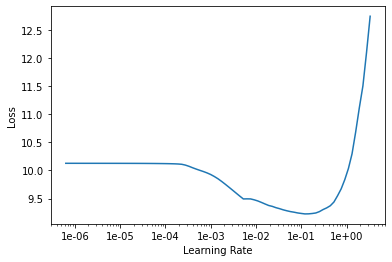

In [24]:
learn.recorder.plot()

In [25]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))
learn.save('first', with_opt=True)

epoch,train_loss,valid_loss,accuracy,time
0,3.348306,3.313400,0.475352,56:28


In [27]:
weights = list(learn.model.parameters())
len(weights)

14

In [28]:
with open('weights.txt', 'w') as f:
    for item in weights:
        f.write("%s\n" % item)

In [29]:
learn.load('first', with_opt=True)

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (67162 items)
x: LMTextList
▁x x bo s ▁జిల్ల ు ంద ▁శ్రీకాకుళం ▁జిల్లా , ▁కంచి లి ▁మండలం ▁లోని ▁గ్రామం . ▁ఇది ▁మండల ▁కేంద్రమైన ▁కంచి లి ▁నుండి ▁8 ▁కి . ▁మీ . ▁దూరం ▁లోను , ▁సమీప ▁పట్టణమైన ▁ఇచ్ఛాపురం ▁నుండి ▁19 ▁కి . ▁మీ . ▁దూరంలోనూ ▁ఉంది . ▁2011 ▁భారత ▁జనగణన ▁గణాంకాల ▁ప్రకారం ▁ఈ ▁గ్రామం ▁126 ▁ఇళ్లతో , ▁5 25 ▁జనాభాతో ▁10 2 ▁హెక్టార్లలో ▁విస్తరించి ▁ఉంది . ▁గ్రామంలో ▁మగవారి ▁సంఖ్య ▁2 67 , ▁ఆడవారి ▁సంఖ్య ▁25 8. ▁షెడ్యూల్డ్ ▁కులాల ▁సంఖ్య ▁33 ▁కాగా ▁షెడ్యూల్డ్ ▁తెగల ▁సంఖ్య ▁0. ▁గ్రామం ▁యొక్క ▁జనగణన ▁లొకేషన్ ▁కోడ్ ▁58 03 93 [1]. పిన్ ▁కోడ్ : ▁532 29 1. ▁సమీప ▁ప్రాథమిక ▁ఆరోగ్య ▁ఉప ▁కేంద్రం ▁గ్రామం ▁నుండి ▁5 ▁కి . మీ . ▁లోపు ▁దూరంలో ▁ఉంది . ▁ప్రాథమిక ▁ఆరోగ్య ▁కేంద్రం ▁గ్రామం ▁నుండి ▁5 ▁నుండి ▁10 ▁కి . మీ . ▁దూరంలో ▁ఉంది . ▁అలోపతి ▁ఆసుపత్రి , ▁ప్రత్యామ్నాయ ▁ఔషధ ▁ఆసుపత్రి , ▁పశు ▁వైద్యశాల , ▁సంచార ▁వైద్య ▁శాల ▁గ్రామం ▁నుండి ▁5 ▁నుండి ▁10 ▁కి . మీ . ▁దూరంలో ▁ఉన్నాయి . ▁సమీప ▁సామాజిక ▁ఆరోగ్య ▁కేంద్రం , ▁మాతా ▁శిశు ▁సంరక్షణ ▁కేంద్రం , ▁టి . ▁బి

In [30]:
np.exp(3.313400)

27.478393364076332

In [31]:
TEXT = "ఇది మండల కేంద్రమైన రంపచోడవరం నుండి"
N_WORDS = 20
N_SENTENCES = 2

In [32]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.9) for _ in range(N_SENTENCES)))

ఇది మండల కేంద్రమైన రంపచోడవరం నుండి ▁25 ▁కి . ▁మీ . ▁దూరం ▁లోను , ▁సమీప ▁పట్టణమైన ▁అనకాపల్లి ▁నుండి ▁99 ▁కి . ▁మీ . ▁దూరంలోనూ ▁ఉంది .
ఇది మండల కేంద్రమైన రంపచోడవరం నుండి ▁16 ▁కి . ▁మీ . ▁దూరం ▁లోను , ▁సమీప ▁పట్టణమైన ▁విశాఖపట్నం ▁నుండి ▁50 ▁కి . ▁మీ . ▁దూరంలోనూ ▁ఉంది .


In [33]:
defaults.device = torch.device('cpu')
learn.model.eval()
learn.export()


In [34]:
!cp -r 'export.pkl' 'drive/My Drive/nlp-telugu/ulmfit2/'

In [35]:
defaults.device = torch.device('cpu')

In [36]:

learn = load_learner('./')

In [37]:
encoder = get_model(learn.model)[0]

In [38]:

encoder.state_dict()['encoder.weight'].shape

torch.Size([25000, 400])

In [39]:
embeddings = encoder.state_dict()['encoder.weight']

In [40]:

embeddings = np.array(embeddings)

In [41]:
embeddings[0].shape

(400,)

In [42]:
df = pd.DataFrame(embeddings)

In [43]:
df.shape

(25000, 400)

In [44]:
df.to_csv('embeddings.tsv', sep='\t', index=False, header=False)

In [45]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399
0,-0.304962,-0.854125,0.816927,-0.740171,0.114643,0.523756,0.567492,-0.207351,0.063229,0.267931,-0.127489,-0.494844,-0.303849,0.044972,-0.530967,-0.261266,-0.044202,0.631450,0.593543,-0.995314,-0.343815,-0.486484,-0.044174,0.442429,0.538471,0.366671,0.156149,-0.403572,-0.016612,-0.710529,0.705373,0.424650,-0.255136,0.142327,-0.464489,-0.664031,-0.460452,-0.136525,-0.143910,-0.152036,...,0.473137,-0.457397,-0.187661,-0.364001,0.534615,0.601249,0.513841,-0.804697,-0.160191,-0.467041,-0.429514,0.143800,0.370680,0.333282,-0.346054,-0.381931,-0.602253,-0.195652,0.183071,0.349388,0.622284,-0.140413,-0.073941,0.080385,-0.203360,-0.294157,-0.373519,-0.157722,-0.019439,0.740854,0.364073,-0.361380,-0.149707,0.523514,-0.557687,0.138733,0.279454,0.180209,0.072430,-0.176718
1,0.746587,-0.287359,0.804313,-0.291460,0.019184,-0.341141,-0.505657,0.441672,-0.242139,-0.339776,0.604874,0.124446,-0.341270,-0.511516,0.448505,-0.615291,-0.401169,0.157039,0.570236,0.394872,0.299136,0.003173,0.112313,-0.568661,0.119387,0.052189,0.830618,0.418727,-0.081045,-0.132129,0.281188,-0.391828,0.104731,-0.060997,0.552361,-0.004031,0.815312,0.287707,-0.160178,-0.355247,...,0.390930,0.753506,-0.544181,0.064992,-0.176855,0.162843,0.154716,0.577337,0.307820,-0.413491,0.352792,-0.225529,0.353234,0.086575,0.263974,0.840016,0.379274,-0.135659,0.445744,0.242938,-0.479606,0.050606,0.059206,-0.094526,-0.270256,0.080543,-0.301498,0.299762,-0.296878,-0.119959,0.464552,0.569265,0.218299,-0.786998,-0.331638,-0.271604,-0.407449,0.060154,0.455422,0.404388
2,0.769267,-0.261309,0.823631,-0.294262,-0.039134,-0.394921,-0.504443,0.486751,-0.285002,-0.365318,0.643396,0.178157,-0.314023,-0.549288,0.416143,-0.651169,-0.441695,0.099569,0.618936,0.398066,0.325331,0.028444,0.114136,-0.533256,0.100795,0.056511,0.836828,0.447610,-0.095906,-0.153727,0.260835,-0.407247,0.114020,-0.067179,0.580001,-0.004042,0.854286,0.259031,-0.106171,-0.305799,...,0.427773,0.799607,-0.549336,0.090591,-0.198922,0.195736,0.157957,0.584652,0.356541,-0.442383,0.303723,-0.215909,0.339207,0.129659,0.259664,0.841290,0.358249,-0.161460,0.443426,0.225453,-0.489818,0.059461,0.076043,-0.060593,-0.245187,0.092447,-0.286135,0.310124,-0.345357,-0.172597,0.505126,0.598452,0.217255,-0.711612,-0.356259,-0.254720,-0.354614,0.041928,0.467525,0.400152
3,-0.620579,-0.099209,-0.107510,0.398823,-0.704297,0.437214,0.785910,-1.302272,-0.612475,0.243462,-0.115222,0.413777,0.502825,-0.056071,-1.048623,0.411073,-0.401093,-3.063387,0.106645,0.427078,0.345168,0.031384,-0.561818,-0.076246,-0.474677,0.343013,1.843250,0.470708,-0.198929,0.029359,0.289392,0.573965,-0.601925,0.120501,-0.590043,-0.181074,-0.278223,0.143104,-0.534476,-0.057400,...,0.175021,-0.064035,-0.719035,0.394193,0.724353,0.510206,-0.043973,-0.228323,-0.438245,2.000589,0.409846,0.092057,0.242264,-0.512247,0.494762,0.380122,-0.736651,-0.114597,-0.368947,-0.293515,0.815657,-0.483516,0.155370,0.241767,0.235171,-0.130183,0.887547,0.366925,0.228319,0.470504,0.187413,-0.328805,0.642919,0.008046,-0.227374,1.077651,0.037076,-0.423753,0.025132,-0.534436
4,-0.414823,-0.635927,-0.168363,0.204977,-0.359367,0.267996,0.340700,-0.459147,0.103022,0.653587,-0.030151,-0.018544,0.540171,-0.071589,-1.518104,0.426200,0.126203,-1.459758,-0.372255,0.297586,-0.159065,0.152726,-0.263560,0.402611,-0.623115,0.259674,-0.375520,-0.148706,-0.405335,0.405485,0.409084,0.396358,-0.274483,0.167922,-0.275610,-0.169778,-0.180784,-0.037098,-0.102796,-0.143907,...,0.362177,-0.476263,0.159471,-0.241494,-0.062115,-0.385262,0.169125,-0.215646,-0.231334,0.525789,-0.223327,-0.093529,-0.197122,0.193389,0.039237,-0.246232,-0.232415,-0.261336,-0.673571,-0.057225,0.721375,-0.097261,-0.225245,0.599799,0.435519,-0.367488,0.380120,0.269556,0.216859,0.7

In [46]:
df2 = pd.DataFrame(itos)
df2.shape

(25000, 1)

In [47]:
df2.head()

,0
0,<unk>
1,<s>
2,</s>
3,.
4,","


In [48]:

df2.to_csv('embedding_metadata.tsv', sep='\t', index=False, header=False)

In [50]:
!cp -r 'embedding_metadata.tsv' 'drive/My Drive/nlp-telugu/ulmfit2/'